In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
from preprocessing import *
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [2]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """
    return np.searchsorted(t, t_scalar, side="right")

In [11]:
def m5_compensator_helper(t_scalar, t_prime, durations):
    """
    Compute the lists that are required for the compensator function but don't depend on the parameters
    """
    t_prime_difference = t_scalar - t_prime[:N(t_scalar, t_prime)]
    d_prime_1 = durations[:N(t_scalar, t_prime)] - 1
    d_prime_30 = np.absolute(durations[:N(t_scalar, t_prime)] - 30)

    return t_prime_difference, d_prime_1, d_prime_30

def m5_recursion_helper(t, t_prime, durations):
    """
    Compute the lists required for the recursive definitions of B_i and C_i
    """
    T = end_T
    time_differences = [] # Holds time differences t_ih - t'_ik
    d1_values = [] # Holds values d'_ik - 1
    d30_values = [] # Holds values |d'_ik - 30|

    for h in range(1, N(T, t)):
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list = t[h] - t_prime[N(t[h-1], t_prime):N(t[h], t_prime)]

        # Construct list of d_ik - 1 for k = 1 to N'(T)
        d1_values_list = durations[N(t[h-1], t_prime):N(t[h], t_prime)] - 1

        # Construct list of |d_ik - 30| for k = 1 to N'(T)
        d30_values_list = np.absolute(durations[N(t[h-1], t_prime):N(t[h], t_prime)] - 30)

        time_differences.append(differences_list)
        d1_values.append(d1_values_list)
        d30_values.append(d30_values_list)

    #print("--")
    #print(time_differences)
    #print(d1_values)
    #print(d30_values)
    #print("--")

    return time_differences, d1_values, d30_values

In [12]:
def compensator_m5(t_scalar, compensator_helpers, 
      lambda_i, alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime):
    """
    Evaluate compensator function for model 5.

    t_scalar: Scalar value at which we evaluate the compensator
    t_prime_precomputed: time differences (t_scalar - t_prime[:N(t_scalar, t_prime)]) array computed outside the function for efficiency
    durations: array of journey durations d'_{i,k} for each arrival time t'_{i,k} at station i
    The rest are parameters in model 5.   
    """
        
    t_prime_precomputed = compensator_helpers[0]
    d_prime_1 = compensator_helpers[1]
    d_prime_30 = compensator_helpers[2]


    term1_comp = lambda_i * t_scalar
    
    term2_comp = -(alpha_i / beta_i_prime) * np.sum(np.exp(-beta_i_prime * (t_prime_precomputed) - beta_i * d_prime_1)-1)

    term3_comp = -(gamma_i / delta_i_prime) * np.sum(np.exp(-delta_i_prime * (t_prime_precomputed) - delta_i * d_prime_30)-1)

    return term1_comp + term2_comp + term3_comp

In [13]:
def B_i(h, t, t_prime, durations, beta_i, beta_i_prime, recursion_helpers):

    """
    Returns a list of [B_i(1), ..., B_i(h)] for model 5

    NOTE: All index variables such as h, k, etc start at 1, like the mathematical notation.
    """

    B = [np.sum(np.exp(-beta_i * (durations[:N(t[0], t_prime)] - 1)) * np.exp(-beta_i_prime*(t[0] - t_prime[:N(t[0], t_prime)])))]

    time_differences = recursion_helpers[0]
    d1_values = recursion_helpers[1]
    #d30_values = recursion_helpers[2]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for B_i(h)
        term1_B = np.exp(-beta_i_prime*(t[l-1] - t[l-2])) * B[l-2]

        term2_B = np.sum(np.exp(-beta_i * (d1_values[l-2])) * np.exp(-beta_i_prime*(time_differences[l-2])))
        B.append(term1_B + term2_B)

    return np.array(B)
    

def C_i(h, t, t_prime, durations, delta_i, delta_i_prime, recursion_helpers):

    """
    Returns a list of [C_i(1), ..., C_i(h)] for model 5

    NOTE: all index variables such as h, k, etc start at 1, like the mathematical notation.
    """

    C = [np.sum(np.exp(-delta_i * np.absolute(durations[:N(t[0], t_prime)] - 30)) * np.exp(-delta_i_prime*(t[0] - t_prime[:N(t[0], t_prime)])))]

    time_differences = recursion_helpers[0]
    #d1_values = recursion_helpers[1]
    d30_values = recursion_helpers[2]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for C_i(h)
        term1_C = np.exp(-delta_i_prime*(t[l-1] - t[l-2])) * C[l-2]
        term2_C = np.sum(np.exp(-delta_i * (d30_values[l-2])) * np.exp(-delta_i_prime*(time_differences[l-2])))
        C.append(term1_C + term2_C)

    return np.array(C)

In [14]:
def m5_log_likelihood(t, t_prime, durations, compensator_helpers, recursion_helpers, lambda_i,
 alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime):
   
   T = end_T

   B_ = B_i(len(t), t, t_prime, durations, beta_i, beta_i_prime, recursion_helpers)

   C_ = C_i(len(t), t, t_prime, durations, delta_i, delta_i_prime, recursion_helpers)

   term1_log_l = np.sum(np.log(lambda_i + alpha_i*B_ + gamma_i*C_))

   term2_log_l = -compensator_m5(T, compensator_helpers, lambda_i, alpha_i,
      beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime)

   return term1_log_l + term2_log_l

In [15]:
durations_per_end_time[1]


array([38.01816768, 27.61916584, 12.87627819, ...,  6.10353135,
       21.05581974,  7.61829541])

In [16]:
# Test m5 likelihood function

t = t_per_station[2]
t_prime = t_prime_per_station[2]
durations = durations_per_end_time[2]
compensator_helpers = m5_compensator_helper(end_T, t_prime, durations)
recursion_helpers = m5_recursion_helper(t, t_prime, durations)

print(m5_log_likelihood(t, t_prime, durations,
    compensator_helpers, recursion_helpers, 0.1, 0.01, 0.1, 0.1, 0.1, 0.01, 0.011))



-68803.20490813418


In [17]:
def test_m5_log_likelihood(t, t_prime, durations, compensator_value, lambda_i,
 alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime):
   
  T = 4

  term1_log_l = 0
  for j in range(len(t)):

    sum1 = 0
    sum2 = 0
    for k in range(N(t[j], t_prime)):
      sum1 += alpha_i * np.exp(-beta_i * (durations[k] - 1)) * np.exp(-beta_i_prime * (t[j] - t_prime[k]))
      sum2 += gamma_i * np.exp(-delta_i * np.absolute(durations[k] - 30)) * np.exp(-delta_i_prime * (t[j] - t_prime[k]))

    lambda_star_j = lambda_i + sum1 + sum2

    term1_log_l += np.log(lambda_star_j)

  term2_log_l = -compensator_value

  return term1_log_l + term2_log_l

In [18]:
# Test likelihood numerically
t = np.array([1, 2, 3])
t_prime = np.array([0.5, 1.5, 2.5])
durations = np.array([2, 2, 2])
T = end_T

lambda_i = 0.1
alpha_i = 0.1
beta_i = 0.1
beta_i_prime = 0.5
gamma_i = 0.1
delta_i = 0.1
delta_i_prime = 0.5

compensator_helpers = m5_compensator_helper(T, t_prime, durations)
recursion_helpers = m5_recursion_helper(t, t_prime, durations)

compensator_value = compensator_m5(T, compensator_helpers, lambda_i, alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime)

print(test_m5_log_likelihood(t, t_prime, durations, compensator_value, lambda_i,
 alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime))

print(m5_log_likelihood(t, t_prime, durations, compensator_helpers, recursion_helpers, lambda_i,
 alpha_i, beta_i, beta_i_prime, gamma_i, delta_i, delta_i_prime))


-12101.844586840994
-12101.844586840994


In [162]:
condensed_log_l_m5 = lambda time_params, model_params: m5_log_likelihood(time_params[0],time_params[1], time_params[2], time_params[3], time_params[4], model_params[0], model_params[1], model_params[2], model_params[3], model_params[4], model_params[5],  model_params[6])

In [25]:
t_prime_per_station[1][1]

576.8620339943299

In [26]:
compensator_helper_dict = {}
recursion_helper_dict = {}
for st_id in tqdm(train_sorted_start_ids):
    compensator_helper_dict[st_id] = m5_compensator_helper(end_T, t_prime_per_station[st_id], durations_per_end_time[st_id])
    recursion_helper_dict[st_id] = m5_recursion_helper(t_per_station[st_id], t_prime_per_station[st_id], durations_per_end_time[st_id])

100%|██████████| 789/789 [00:37<00:00, 20.96it/s]


In [27]:
time_params_dict = {}
for st_id in tqdm(train_sorted_start_ids):
    time_params_dict[st_id] = [t_per_station[st_id], t_prime_per_station[st_id],
    durations_per_end_time[st_id], compensator_helper_dict[st_id], recursion_helper_dict[st_id]]


100%|██████████| 789/789 [00:00<00:00, 28086.38it/s]


In [28]:
def transform_params(params):
    if len(params) != 7:
        raise ValueError("Not the right size.")
    lambda_i, alpha_i, beta_i,\
         beta_i_prime, gamma_i, \
            delta_i, delta_i_prime = params
    return [np.exp(lambda_i), np.exp(alpha_i), np.exp(beta_i),
     np.exp(alpha_i) + np.exp(beta_i_prime), np.exp(gamma_i),
     np.exp(delta_i), np.exp(gamma_i) + np.exp(delta_i_prime)]

In [30]:
unconverged_it1 = []
N_stat = 5
optimal_parameters_it1 = {}
for st_id in tqdm(train_sorted_start_ids[:N_stat]):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    #x0 = np.random.random(7)/10
    x0 = np.ones(7) * -20
    op_m5_log_likelihood = lambda x: -condensed_log_l_m5(time_params_dict[st_id], transform_params(x))
    sol = op.minimize(op_m5_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        max_params = transform_params(sol.x)
        optimal_parameters_it1[st_id] = max_params
    else:
        unconverged_it1.append(st_id)
        print(f"{st_id} failed to converge.")

 40%|████      | 2/5 [01:38<02:48, 56.21s/it]

2 failed to converge.


 60%|██████    | 3/5 [02:03<01:23, 41.98s/it]

3 failed to converge.


 80%|████████  | 4/5 [02:33<00:37, 37.54s/it]

4 failed to converge.


100%|██████████| 5/5 [03:32<00:00, 42.42s/it]


In [32]:
unconverged_it2 = []
N_stat = 5
for st_id in tqdm(unconverged_it1):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    #x0 = np.random.random(7)/10
    x0 = np.ones(7) * -15
    op_m5_log_likelihood = lambda x: -condensed_log_l_m5(time_params_dict[st_id], transform_params(x))
    sol = op.minimize(op_m5_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        max_params = transform_params(sol.x)
        optimal_parameters_it1[st_id] = max_params
    else:
        unconverged_it2.append(st_id)
        print(f"{st_id} failed to converge.")

 67%|██████▋   | 2/3 [01:44<00:47, 47.51s/it]

3 failed to converge.


100%|██████████| 3/3 [02:15<00:00, 45.06s/it]


In [34]:
unconverged_it3 = []
for st_id in tqdm(unconverged_it2):
    # m2_station_params = model_2_params.loc[st_id].to_numpy()
    # m3_station_params = model_3_params.loc[st_id].to_numpy()
    #x0 = [np.log(m2_station_params[0]), np.log(m2_station_params[1] -m2_station_params[0] ), np.log(m3_station_params[0]), np.log(m3_station_params[1] - m3_station_params[0]), np.log(m3_station_params[-1])] # np.log(rates_dict[station.start_id.unique()[0]])]
    #x0 = np.random.random(7)/10
    x0 = np.ones(7) * -25
    op_m5_log_likelihood = lambda x: -condensed_log_l_m5(time_params_dict[st_id], transform_params(x))
    sol = op.minimize(op_m5_log_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        max_params = transform_params(sol.x)
        optimal_parameters_it1[st_id] = max_params
    else:
        unconverged_it3.append(st_id)
        print(f"{st_id} failed to converge.")

100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


In [35]:
optimal_parameters_it1

{1: [0.003629396030872569,
  1.4517159232852966e-14,
  9.150791508718783e-09,
  4.0398602160815666e-13,
  0.00029506345007976326,
  1.6015065318240352e-09,
  0.0002950634500819004],
 5: [0.0003845914358965158,
  1.611986218985899e-07,
  1.6231151064257143e-12,
  1.6202702082491807e-07,
  0.01260736368541474,
  3.9110981241080687e-10,
  0.012607363685414746],
 2: [0.0012155976437397903,
  0.01516405391595542,
  4.301815328910006e-16,
  0.01592549870859946,
  4.4226313094232615e-18,
  1.333304494260269e-09,
  4.9463630485209966e-08],
 4: [0.009703232396035148,
  0.009834011438173553,
  3.0148801022055933e-25,
  0.02377040215762983,
  2.756233751698695e-45,
  23.456407016228276,
  124803519293459.84],
 3: [2.324925462881799e-12,
  0.004664829420861568,
  3.928519207680213e-12,
  0.004664829420864707,
  2.9021858839664384e-11,
  3.3096997805355953e-13,
  3.309967648978796e-11]}

In [49]:
m5_param_df = pd.DataFrame(optimal_parameters_it1.values(), index=optimal_parameters_it1.keys(), columns = ["lambda", "alpha", "beta", "beta_prime", "gamma", "delta", "delta_prime"])
m5_param_df = m5_param_df.sort_index()
m5_param_df.head()

,lambda,alpha,beta,beta_prime,gamma,delta,delta_prime
1,3.629396e-03,1.451716e-14,9.150792e-09,4.039860e-13,2.950635e-04,1.601507e-09,2.950635e-04
2,1.215598e-03,1.516405e-02,4.301815e-16,1.592550e-02,4.422631e-18,1.333304e-09,4.946363e-08
3,2.324925e-12,4.664829e-03,3.928519e-12,4.664829e-03,2.902186e-11,3.309700e-13,3.309968e-11
4,9.703232e-03,9.834011e-03,3.014880e-25,2.377040e-02,2.756234e-45,2.345641e+01,1.248035e+14
5,3.845914e-04,1.611986e-07,1.623115e-12,1.620270e-07,1.260736e-02,3.911098e-10,1.260736e-02


In [46]:
test_compensator_helper_dict = {}
for st_id in tqdm(test_sorted_start_ids[:N_stat]):
    comp_h = lambda t: m5_compensator_helper(t, t_prime_per_station[st_id], durations_per_end_time[st_id])
    test_compensator_helper_dict[st_id] = [comp_h(t) for t in t_per_station[st_id]]

100%|██████████| 5/5 [00:00<00:00, 10.65it/s]


In [56]:
compensated_times_m5 = {}
for st_id in tqdm(test_sorted_start_ids[:N_stat]):
    params = m5_param_df.loc[st_id].to_numpy()
    comp_condensed = lambda t, comp_help: compensator_m5(t, comp_help,
     params[0], params[1], params[2], params[3], params[4], params[5], params[6] )
    compensated_times_m5[st_id] = [comp_condensed(t_per_station[st_id][i], test_compensator_helper_dict[st_id][i]) for i in range(len(t_per_station[st_id]))]

compensated_times_m5[1]

100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


[1.5460324240765597,
 1.809592194325073,
 2.13430180481358,
 2.1423730036016577,
 2.234847717590601,
 2.2838122285192597,
 2.6440174176844473,
 2.7234920574705694,
 3.3130717272619012,
 3.326100246869939,
 4.16964831009292,
 4.685791362192999,
 4.812603038743827,
 4.813979044589702,
 5.095405657498952,
 5.120165043890767,
 5.159083070242131,
 5.16025187423684,
 5.172125581357474,
 5.26390399833698,
 5.342609428808018,
 5.661884058030281,
 5.691945397645891,
 5.763091736824305,
 6.117013866476641,
 10.62760645133784,
 11.22334403298246,
 11.883029099731644,
 11.892574084317776,
 11.934251619219138,
 11.940230754321476,
 12.16133240590904,
 12.287902352227821,
 12.377540554513242,
 12.433537674151893,
 12.435864805352765,
 12.618096422008904,
 13.33619177567915,
 15.152629417456467,
 15.155405115170321,
 15.156747773927524,
 15.1650857598462,
 15.218450610140712,
 15.43771781700103,
 15.445403826291315,
 15.5879622899336,
 15.59397353379769,
 15.819484534442688,
 15.887822862591449,
 16.

In [57]:
m5_p_values = {}

for st_id in tqdm(test_sorted_start_ids[:N_stat]):
    inter_arrival_times = np.diff(compensated_times_m5[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_m5[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m5_p_values[st_id] = station_p_values

100%|██████████| 5/5 [00:00<00:00, 4039.20it/s]


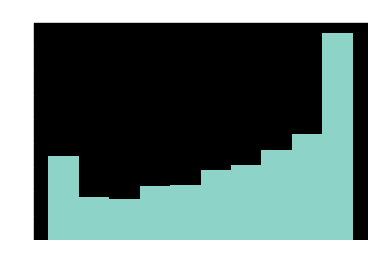

In [58]:
plt.title("Histogram of p-values for station 1 using Model 4")
plt.hist(m5_p_values[1])
plt.show()

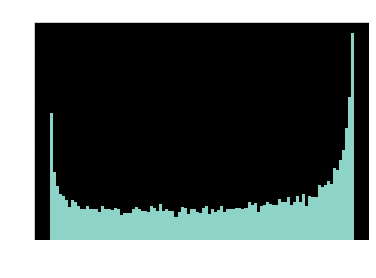

In [60]:
joined_p_values = np.concatenate(np.asarray(list(m5_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 4")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()